<a href="https://colab.research.google.com/github/alecoder1/PyTorch-Tutorial/blob/main/Image_recognition_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

# For evaluation metrics
from sklearn.metrics import confusion_matrix   # OR use torchmetrics (GPU friendly)
# import torchmetrics  # modern metrics library for PyTorch


In [2]:
# Convert MNIST image files into tensors with shape [channels, height, width].
# MNIST tensors are 3D per sample:[C, H, W]
# DataLoader will add the batch dimension: [batch, channels, height, width].

# Define transform: convert to tensor and normalize (MNIST mean/std)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Normalizing the MNIST dataset using its mean=0.1307 and std=0.3081
])


In [3]:
# Train dataset (60,000 examples)
train_data = datasets.MNIST(
    root="data",          # relative path, safer than '/cnn_data'
    train=True,
    download=True,
    transform=transform
)

In [4]:
# Confirming the dataset size
train_data  # should be 60000

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [5]:
# Test dataset (10,000 examples)
test_data = datasets.MNIST(
    root="data",          # safer relative path
    train=False,
    download=True,
    transform=transform
)

In [6]:
# Confirming the dataset size
test_data # should be 60000

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

## DataLoader() Function
- The DataLoader in PyTorch is a wrapper around your dataset (train_data or test_data) that handles:
    1. Batching:
          - Instead of giving one image at a time, it groups data into batches.
          - batch_size=128 → you get a tensor of shape [128, 1, 28, 28].
    2. Shuffling:
        - Randomizes the order of data each epoch (shuffle=True).
        - Prevents the model from memorizing the sequence.
    3. Parallel Data Loading:
        - Uses multiple CPU workers (num_workers) to load and preprocess data in parallel.
        - Speeds up training a lot when your dataset is large.
    4. Automatic Tensor Collation:
        - Takes individual samples from the dataset and stacks them into batches automatically.
        - For example: 10 single [1, 28, 28] images → [10, 1, 28, 28].
    5. Data Streaming:
        - Feeds data batch by batch during training.
        - You don’t need to load the entire dataset into memory.

In [7]:
# Train and test loaders with modern best practices
# Each epoch → DataLoader will generate batches from train_data (60,000 images).
# With batch_size=128 → you get ~469 mini-batches per epoch.
# Model trains much faster than looping through all 60,000 images one by one
train_loader = DataLoader(
    train_data,
    batch_size=128,          # bigger batch size for faster training
    shuffle=True,
    num_workers=2,           # parallel workers
    pin_memory=True,         # speedup for GPU
    persistent_workers=True  # workers reused across epochs
)

test_loader = DataLoader(
    test_data,
    batch_size=256,
    shuffle=False,           # no shuffle for test
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

In [8]:
# Define our CNN Model
# Describe convolutional layer and what its doing (2 convolutional layers)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


#### Explanation:
1.  nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    - Creates a convolutional layer.
2. conv1 = nn.Conv2d(1, 6, 3, 1)
    - Input:  1 channel (MNIST grayscale image - [1, 28, 28])
    - Output: 6 feature maps
    - Kernel size: 3x3 filters
    - Stride: 1 move 1 pixel at a time.
    - So this layer learns 6 filters to extract edges, curves, or simple patterns from the input.
    - Output shape: ([batch, 6, 26, 26] because 28 -3 + 1=26).
3. conv2 = nn.Conv2d(6, 16, 3, 1)
    - Input: 6 channels (output from conv1)
    - Output: 16 feature maps.
    - Kernel size: 3x3.
    -  stride=1
    - This layer learns 16 filters that combine low-level features (edges) into higher level features (like digit strokes).
    - Output shape: ([batch, 16, 24, 24] because 26 - 3 +1=24

In [9]:
## Grab 1 MNIST record/ image
# By directly indexing the dataset
X_train, y_train = train_data[0]

print(X_train.shape) # torch.Size([1, 28, 28])
print(y_train)       # # label (e.g., 5)


torch.Size([1, 28, 28])
5


#### Explanation
1. X_train:
    - From the dataset, it has shape [1, 28, 28]:
        - 1 → channel (grayscale),
        - 28, 28 → height and width.
2. Why reshape?
    - PyTorch convolution layers expect input with 4 dimensions.
    [batch_size, channels, height, width]
    - Right now, X_train is missing the batch dimension.
3. .view(1, 1, 28, 28)
    - Adds a batch dimension of size 1
    - Resulting shape: torch.Size([1, 1, 28, 28])
    - Now it looks like a batch of grayscale image.

In [10]:
# Reshape the MNIST image so it can be fed into the convolutional layers.
x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

#### Summary:
- Before: X_train.shape = [1, 28, 28]
- After: x.shape = [1, 1, 28, 28]
- This is now ready to be passed into conv1(x) or a full CNN model.

##### Using them before building the model class

In [11]:
# Take one batch from trainloader
x.shape

torch.Size([1, 1, 28, 28])

### First Convolution

1. conv1(x):
    - Applies the first convolutional layer to the input image.
    - Recall: conv1 = nn.Conv2d(1, 6, 3, 1)
      - Input shape: [1, 1, 28, 28]
      - Output shape: [1, 6, 26, 26]
    - Now you have 6 feature maps, each 26x26 pixels.

In [12]:
x = conv1(x)  # Applies the first convolutional layer to the input image
x.shape

torch.Size([1, 6, 26, 26])

### Applying activation function
1. F.relu(...)
  - Applies the ReLU activation function(Rectified Linear Unit):
    - ReLU(x) = max(0, x)
  - Why?
    - Convolutions produce both positive and negative values.
    - ReLU sets all negatives to 0; Keeps only strong positive activations.
    - This introduces non-linearity, allowing CNN to learn more complex patterns.
2. Result stored in x has shape:[1, 6, 26, 26]
  - Each of the 6 feature maps highlights different simple patterns (like vertical lines, horizontal strokes, corners)


In [13]:
# And applying an activation function
x = F.relu(x)      # Rectified Linear Unit for our activation function
x.shape

torch.Size([1, 6, 26, 26])

### Max Pooling:
1. Max Pooling:
  - It's a downsampling operation.
  - max_pool2d(x, kernel_size=2, stride=2) means:
    - Look at each non-overlapping 2x2 block in the feature map.
    - Keep only the maximum value from that block.
  - So it reduces the height and width by half, while keeping the number of channels the same.
2. Before pooling:
  - From the previous step: x.shape  = [1, 6, 26, 26]
    - Batch = 1
    - Channels = 6
    - Height = 26
    - Width = 26
3. After pooling:
  - Each 26x26 map becomes 13x13(because 26 / 2 = 13)
  - Shape becomes: [1, 6, 13, 13]
4. Why pooling helps?
  - Reduces computation (fewer pixels to process)
  - Adds translation invariance: The model focuses on whether a feature exists not exactly where.
  - Prevents overfitting by simplifying feature maps.


In [14]:
# pass through the pooling layer
x = F.max_pool2d(x, 2, 2)  # kernel of 2 and stride of 2
x.shape

torch.Size([1, 6, 13, 13])

In [15]:
# Do our second convolutional Layer
x = F.relu(conv2(x))

In [16]:
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
# second pooling layer
x = F.max_pool2d(x, 2,2)
x.shape

torch.Size([1, 16, 5, 5])

### Flattening Step
- The CNN feature maps get converted into a vector for the fully connected (dense) layers.
1. Current shape: x.shape = [1, 16, 5, 5]
2. Flattening:
    - We want to squash the 3D [16, 5, 5] feature mapinto a 1D per image.
    - 16 * 5* 5 = 400
    - So each image becomes a 400-length vector
3. .view(-1, 16*5*5):
    - -1 means "infer the batch size automatically".
    - Shape becomes: [1, 400]
4. Why flatten?
    - Convolution layers capture spatial features.
    - Dense layers use those features to classify the image into digit classes (0-9)


In [18]:
x = x.view(-1, 16 * 5 * 5)
x.shape

torch.Size([1, 400])

### Fully connected layers
- Feed this into a dense layer

In [19]:
fc1 = nn.Linear(16 * 5 * 5, 120)  # first fully connected layer
x = F.relu(fc1(x))                # apply ReLU
x.shape

torch.Size([1, 120])

# Second fully connected layer

In [20]:
fc2 = nn.Linear(120, 84)
x = F.relu(fc2(x))
x.shape

torch.Size([1, 84])

### Explanation
1. Input size = 120 (from fc1)
2. Output size = 84 neurons
    - Again this is a design choice -> fewer neurons -> more compressions
    - Helps the model focus on key features
3. Activation (ReLU)
    - keeps network expressive.
4. Shape transformation
    - input shape:[1, 120]
    - Output shape:[1, 84]

### Output classifier

In [21]:
fc3 = nn.Linear(84, 10)
x = fc3(x)
x.shape

torch.Size([1, 10])

#### Explanation
1. input size = 84 (from fc2)
2. Output size = 10 neurons -> one for each digit(0-9)
3. No ReLU at the end:
    - The raw outputs (called logits) are passed into a loss function (e.g.., nn.CrossEntropyLoss) which internally applies softmax
4. Shape transformation:
    - Input shape: [1, 84]
    - Output shape: [1, 10]

In [22]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    # Fully connected layers
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(X.size(0), -1)  # flatten dynamizally

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)             # raw digits

    return X



#### Checking the shape of the data before it goes into the model
1. for X, y in train_loader:
    

In [23]:

# x = batch of images
# y = batch of labels
# torch.size([128, 1, 28, 28]): batch_size=128, 1: channel(grayscale), 28X28 : image_size
# labels are 1D tensor of size batch_size

for X, y in train_loader: # iterates through yor training data batch by batch
  print("X.shape:", X.shape)
  print("y_shape:", y.shape)
  break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


X.shape: torch.Size([128, 1, 28, 28])
y_shape: torch.Size([128])


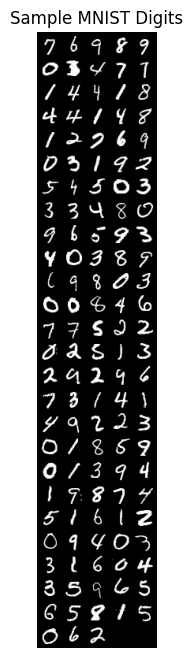

Labels: [7, 6, 9, 8, 9, 0, 3, 4, 7, 7, 1, 4, 4, 1, 8, 4, 4, 1, 4, 8, 1, 2, 7, 6, 9, 0, 3, 1, 9, 2, 5, 4, 5, 0, 3, 3, 3, 4, 8, 0, 9, 6, 5, 9, 3, 4, 0, 3, 8, 9, 6, 9, 8, 0, 3, 0, 0, 8, 4, 6, 7, 7, 5, 2, 2, 0, 2, 5, 1, 3, 2, 9, 2, 9, 6, 7, 3, 1, 4, 1, 4, 9, 2, 2, 3, 0, 1, 8, 5, 9, 0, 1, 3, 9, 4, 1, 9, 8, 7, 4, 5, 1, 6, 1, 2, 0, 9, 4, 0, 3, 3, 1, 6, 0, 4, 3, 5, 9, 6, 5, 6, 5, 8, 1, 5, 0, 6, 2]


In [24]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Grab one batch
X, y = next(iter(train_loader)) # grabs the first batch

# Make a grid of images (normalize for display)
# normalize=True: ensures pixel values are scaled nicely for visualization
grid = make_grid(X, nrow=5, normalize=True) # arranges the images in a nice grid(5 per row)

# Convert from tensor to numpy for plotting
# plt.imshow(..) displays the grid of images
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))  # change from [C,H,W] to [H,W,C]
plt.title("Sample MNIST Digits")
plt.axis("off")
plt.show()

print("Labels:", y.tolist()) # shows the labels for the batch


In [25]:
C = X.shape[1]
print(C)

1


#### Instantiating our model
- We have defined the class ConvolutionalNetwork
- We make an instance of the class ConvolutionalNetworks.
- That's like writing the blueprint of a house and building the house.

In [26]:
# instanstiate our class
torch.manual_seed(42) # Sets the random seed for PyTorch; ensures that weight initialization is reproducible, is you run you will get the same initial random weights
we_model = ConvolutionalNetwork()
we_model # prints the architecture summary.

# NOW MODEl HAS:
# 2 convolutional layers (conv1, conv2)
# 3 fully connected layers(fc1, fc2, fc3)

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
# Confirm model accepts the number of channels
C = X.shape[1]
print("Data channels:", C)
print("Model conv1.input_channels:", we_model.conv1.in_channels)


Data channels: 1
Model conv1.input_channels: 1


### Final Sanity check before training: Forward pass
1.  Make sure the the model's forward pass works and produces the expected output shape.

2. out = model(X)
  - Sends that batch of images through the entire CNN.
    - Conv1 → ReLU → Pool
    - Conv2 → ReLU → Pool
    - Flatten → FC1 → ReLU → FC2 → ReLU → FC3
    - Produces raw class scores (logits).
3. Expected Output shape
    - out.shape = [128, 10]
      - 128 rows = batch_size (one output per image)
      - 10 columns = logits for each digit class (0-9).

### 4. Why this chech matters;
- Confirms your data tensor shape matches what the model expects.
- Confirms the final layer outputs the right number of classes.
- Prevents nasty runtime errors later when computing the loss.


In [28]:
# Testing the forward pass
# to confirm the output shape
X, y = next(iter(train_loader)) # get one batch from the training loader.
                                # X.shape = [128, 1, 28, 28]; y.shape = [10]
out = we_model(X)                # forward pass
print("Input shape:", X.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([128, 1, 28, 28])
Output shape: torch.Size([128, 10])


#### Defining the Loss Function()
1. For classification:
    - criterion = nn.CrossEntropyLoss()
      - This is the standard loss for multi-class classification
      - Takes raw digits from your model (out) and compares them against interger labels(y).
      - Iternally;
          - CrossEntropyLoss = LogSoftmax + NegativeLogLikelihoodLoss
      - That is why we don't need to apply F.log_softmax in the model the loss handles it.
2. optimizer = torch.optim.Adam(we_model.parameters(), lr=0.001, weight_decay=1e-4)
    - Optimizer = Adam (adaptive learning rate per parameter)
    - we_model.parameters() tells th optimizer which weights to update.
    - lr=0.001: is the default recommended learning rate for Adam.
    - Smaller learning rate = more stable but slower training.
    - Larger rate = faster but riskier.
    - Add weight_decay for regularization (prevents overfitting).
    - Adding a learning rate scheduler for smoother convergence.
      


In [29]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(we_model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler (Optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#### Modern PyTorch Training Loop


In [30]:
# keep track of time
import time
start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
we_model.to(device) # Move the model to the GPU if availabl else cpu

epochs = 5
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(epochs):
  we_model.train()
  running_loss, correct = 0.0, 0

  for batch_idx, (X_train, y_train) in enumerate(train_loader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Forward pass
    y_pred = we_model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Metrics
    running_loss += loss.item()
    predicted = torch.argmax(y_pred, dim=1)
    correct += (predicted == y_train).sum().item()

    # Print out some results every 100 batches
    if (batch_idx + 1) % 100 == 0:
      print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} | Train Loss: {running_loss/100:.4f}')
      running_loss = 0.0 # Reset running loss for the next 100 batches


  epoch_loss = running_loss / (len(train_loader)%100) if len(train_loader)%100 != 0 else running_loss/100 # Handle the remaining batches
  epoch_acc = correct / len(train_data)
  train_losses.append(epoch_loss)
  train_acc.append(epoch_acc)


  # -----Test phase-----
  we_model.eval()
  running_loss, correct = 0.0, 0
  with torch.no_grad(): # No gradient so we don't update our weights and biases with test data
    for X_test, y_test in test_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_val = we_model(X_test)
      loss = criterion(y_val, y_test)

      running_loss += loss.item()
      predicted = torch.argmax(y_val, dim=1) # Adding up correct predictions
      correct += (predicted == y_test).sum().item() # T=1 F=0 and sum away

  epoch_loss = running_loss / len(test_loader)
  epoch_acc = correct / len(test_data)
  test_losses.append(epoch_loss)
  test_acc.append(epoch_acc)
  print(f'Epoch: {epoch+1}/{epochs} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_acc[-1]:.4f}')


current_time = time.time()
total = current_time - start_time
print(f"Training Took:{total/60:.2f} minutes!")

Epoch: 1/5 | Batch: 100/469 | Train Loss: 0.8367
Epoch: 1/5 | Batch: 200/469 | Train Loss: 0.2570
Epoch: 1/5 | Batch: 300/469 | Train Loss: 0.1714
Epoch: 1/5 | Batch: 400/469 | Train Loss: 0.1401
Epoch: 1/5 | Test Loss: 0.0919 | Test Acc: 0.9709
Epoch: 2/5 | Batch: 100/469 | Train Loss: 0.1056
Epoch: 2/5 | Batch: 200/469 | Train Loss: 0.0973
Epoch: 2/5 | Batch: 300/469 | Train Loss: 0.0932
Epoch: 2/5 | Batch: 400/469 | Train Loss: 0.0816
Epoch: 2/5 | Test Loss: 0.0586 | Test Acc: 0.9798
Epoch: 3/5 | Batch: 100/469 | Train Loss: 0.0670
Epoch: 3/5 | Batch: 200/469 | Train Loss: 0.0658
Epoch: 3/5 | Batch: 300/469 | Train Loss: 0.0681
Epoch: 3/5 | Batch: 400/469 | Train Loss: 0.0654
Epoch: 3/5 | Test Loss: 0.0499 | Test Acc: 0.9835
Epoch: 4/5 | Batch: 100/469 | Train Loss: 0.0472
Epoch: 4/5 | Batch: 200/469 | Train Loss: 0.0530
Epoch: 4/5 | Batch: 300/469 | Train Loss: 0.0472
Epoch: 4/5 | Batch: 400/469 | Train Loss: 0.0540
Epoch: 4/5 | Test Loss: 0.0400 | Test Acc: 0.9859
Epoch: 5/5 | Bat

#### Graph the Loss at each Epoch

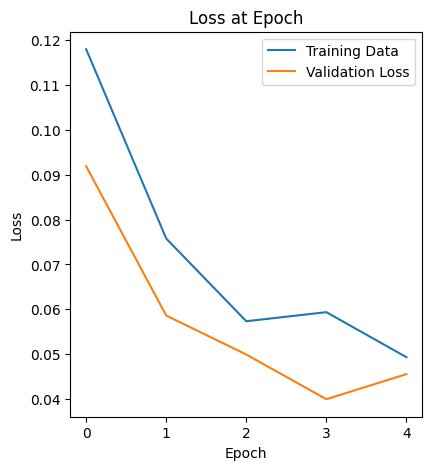

In [31]:
# Graph the loss at Epoch
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Data")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
%matplotlib inline

In [32]:
print(test_acc)

[0.9709, 0.9798, 0.9835, 0.9859, 0.9839]


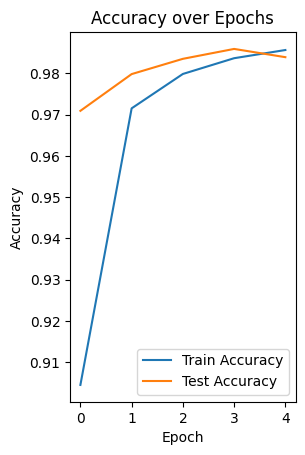

In [33]:

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


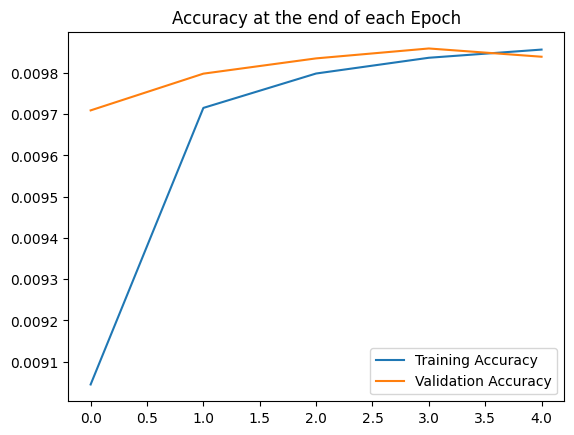

In [34]:
# Graph the accuracy at the end of each epoch
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([t/100 for t in train_acc], label="Training Accuracy")
plt.plot([t/100 for t in test_acc], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [44]:
# Evaluate your full dataset
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)


In [45]:
we_model.eval()
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_val = we_model(X_test)
    predicted = torch.argmax(y_val, dim=1)
    correct += (predicted == y_test).sum().item()



In [46]:
test_acc

98.39

In [48]:
# Did for correct?
test_acc = correct / len(test_data) * 100
print(f"Final Test Accuracy: {test_acc}")

Final Test Accuracy: 98.39


#### Sending an Image into the CNN Model

In [59]:
# Grab an Image
test_data[1976]   # Gives us a tensor with an image in it..at end it showss the label

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

In [60]:
# Grab just the data
test_data[1976][0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [61]:
# Reshape it
test_data[1976][0].reshape(28,28)

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

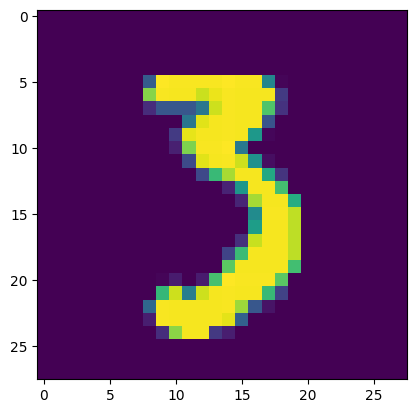

In [62]:
# Show the image
plt.imshow(test_data[1976][0].reshape(28,28))


In [63]:
# Pass the image through our model
we_model.eval()
with torch.no_grad():
  # batch_size of 1, 1 color channel, 28x28 image
  new_prediction = we_model(test_data[1976][0].view(1,1,28,28))


In [64]:
# Check the new prediction..get probabilities
new_prediction

tensor([[-3.6276,  2.3373, -2.6343,  9.4116, -7.3343,  3.1283, -4.5179, -2.1593,
         -2.6807,  0.5801]])

In [65]:
new_prediction.argmax()

tensor(3)